In [99]:
import os
from collections import Counter
from itertools import combinations

from path
import matplotlib as mpl
import scipy as sp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ete3 import Tree

In [73]:
# ploting settings
plt.style.use("~/projects/CELL_LINEAGE/NOTES/Plot/sloth_paper.mplstyle")
os.environ["QT_QPA_PLATFORM"] = "offscreen"

%config InlineBackend.figure_format = "svg"
%matplotlib inline

In [134]:
NPG_WIDTH2 = 183 / 25.4
NPG_WIDTH = 89 / 25.4
NPG_HEIGHT = 247 / 25.4
GOLDEN_RATIO = (1 + 5 ** 0.5) / 2


def preorder_gridspec(subspec, label=None, lab_x_pad=0.18, lab_y_pad=0.16, lab_case="lower"):
    """
    eg: subspec = gs[:2, 2:3]
    fix args:
    lab fontsize = 16
    lab fontweight = 'bold'
    """
    if lab_case == "lower":
        label = label.lower()
    if isinstance(subspec.get_gridspec(), mpl.gridspec.GridSpec):
        fig = subspec.get_gridspec().figure
    elif isinstance(subspec.get_gridspec(), mpl.gridspec.GridSpecFromSubplotSpec):
        fig = subspec.get_gridspec()._subplot_spec._gridspec.figure
    else:
        raise TypeError("input must be a gridspec....")
    _, _, grid_x_start, grid_x_end, grid_y_start, grid_y_end = subspec.get_rows_columns()
    ax = fig.add_subplot(subspec)
    if label:
        ax.text(
            -lab_x_pad / (1 + grid_y_end - grid_y_start),
            1 + lab_y_pad / (1 + grid_x_end - grid_x_start),
            label,
            transform=ax.transAxes,
            fontsize=16,
            fontweight="bold",
            va="top",
            ha="right",
        )
    return ax


def as_si(x, ndp, base=True):
    s = "{x:0.{ndp:d}e}".format(x=x, ndp=ndp)
    m, e = s.split("e")
    if not base and m != 1:
        return r"$10^{{{e:d}}}$".format(m=m, e=int(e))
    return r"${m:s}\times 10^{{{e:d}}}$".format(m=m, e=int(e))


as_si(0.234, 2)

'$2.34\\times 10^{-1}$'

In [129]:
def count_connections(tree_name):
    """return leaf number and connection number"""
    tree = Tree(f"./AlexanderSchier_Data/{tree_name}.nwk", format=1)
    df = pd.read_csv(f"./AlexanderSchier_Data/{tree_name}.tsv", sep="\t")
    organ_dict = df.loc[df["is_leaf"], ["short_name", "organType"]].set_index("short_name")["organType"].to_dict()

    organs = []
    connections = []
    for node in tree.traverse("postorder"):
        if node.is_leaf():
            node.organ = {organ_dict[node.name]}
            organs.append(list(node.organ)[0])
        else:
            node.organ = set.union(*[n.organ for n in node.get_children()])
            if all(len(n.organ) == 1 for n in node.get_children()) and len(node.organ) > 1:
                for o1, o2 in combinations(node.organ, 2):
                    connections.append(tuple(sorted([o1, o2])))
    return Counter(organs), Counter(connections)

In [194]:
def plot_expectation_corr(c1, c2, ax):
    # exclude_list = ["Mixed", "Progenitor"]
    exclude_list = ["Mixed"]
    df = pd.DataFrame(
        [[o1, o2, c1[o1] * c1[o2], n2] for (o1, o2), n2 in c2.items() if o1 not in exclude_list and o2 not in exclude_list],
        columns=["Organ1", "Organ2", "Expectation", "Observation"],
    )
    df["Expectation"] = df["Expectation"] / df["Expectation"].sum()
    df["Observation"] = df["Observation"] / df["Observation"].sum()
    # ax.plot(df["Expectation"], df["Observation"], "ro")
    sns.regplot(df["Expectation"], df["Observation"], color="C2", ci=None)
    R, p = sp.stats.pearsonr(df["Expectation"], df["Observation"])
    ax.text(
        0.1,
        0.9,
        # "$R^{2}=" + f"{R**2:0.3f}$\n$p=$" + as_si(p, 2),
        "$R^{2}=" + f"{R**2:0.3f}$",
        ha="left",
        va="top",
        fontsize="xx-large",
        fontweight="normal",
        fontfamily="monospace",
        transform=ax.transAxes,
    )
    # force set ticks
    ax.set_xticks(np.arange(0, df["Expectation"].max() * 1.2, round(df["Expectation"].max() * 1.2 / 4, 2)))
    ax.set_yticks(np.arange(0, df["Observation"].max() * 1.2, 0.05))
    ax.set_xlabel(f"Expected coalescence rate")
    ax.set_ylabel(f"Observed coalescence rate")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return ax

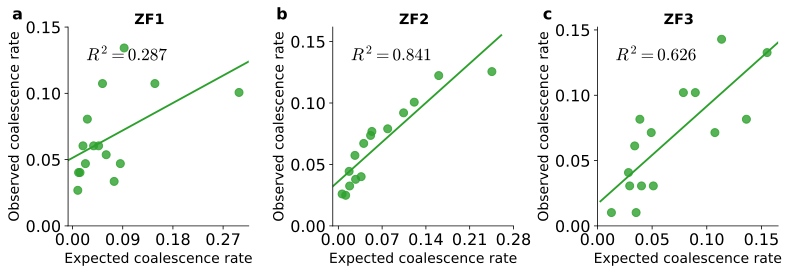

In [195]:
lab_case, lab_x_pad, lab_y_pad = "lower", 0.25, 0.1
fig_width, fig_height = NPG_WIDTH2 * 1.5, NPG_WIDTH2 * 1.5 / 3 
fig = plt.figure(figsize=(fig_width, fig_height), dpi=600)
gs = fig.add_gridspec(1, 3)

ax1 = preorder_gridspec(gs[0, 0], label="A", lab_x_pad=lab_x_pad, lab_y_pad=lab_y_pad, lab_case=lab_case)
ax1.text(0.45, 1, "ZF1", fontsize="x-large", fontweight="bold", va="bottom", ha="center", transform=ax1.transAxes)
plot_expectation_corr(*count_connections("ZF1"), ax1)

ax2 = preorder_gridspec(gs[0, 1], label="B", lab_x_pad=lab_x_pad, lab_y_pad=lab_y_pad, lab_case=lab_case)
ax2.text(0.45, 1, "ZF2", fontsize="x-large", fontweight="bold", va="bottom", ha="center", transform=ax2.transAxes)
plot_expectation_corr(*count_connections("ZF2"), ax2)

ax3 = preorder_gridspec(gs[0, 2], label="C", lab_x_pad=lab_x_pad, lab_y_pad=lab_y_pad, lab_case=lab_case)
ax3.text(0.45, 1, "ZF3", fontsize="x-large", fontweight="bold", va="bottom", ha="center", transform=ax3.transAxes)
plot_expectation_corr(*count_connections("ZF3"), ax3)

fig.tight_layout(pad=0, w_pad=0.6, h_pad=1.2)
#fig.text(1, -0.02, "Extended Data Fig. SX", fontsize="x-large", fontweight="normal", color="silver", va="top", ha="right", transform=fig.transFigure)
fig.savefig(f"./infer_coalescence_by_niche_size_model_with_AlexanderSchier_Data.pdf", dpi=600, orientation="portrait", transparent=True, bbox_inches="tight")
fig.show()

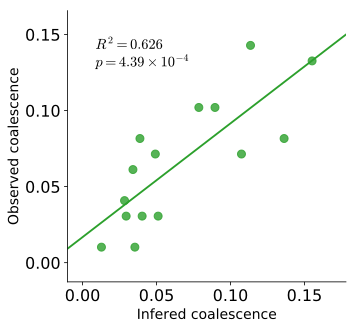

In [180]:
fig, ax = plt.subplots(figsize=(5, 5))
plot_expectation_corr(*count_connections("ZF3"), ax)
fig.show()